In [40]:
# import packages
import requests
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from datetime import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# list of stopwords like articles, preposition
stop = set(stopwords.words('english'))
from string import punctuation
from nltk.stem.porter import PorterStemmer
p_stemmer = PorterStemmer()
from collections import Counter
import re
import lda

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

In [14]:
#CATEGORY: News category (b = business, t = science and technology, e = entertainment, m = health) 
column_names = ['id','title','url','publisher','category','story','hostname','timestamp']
data = pd.read_csv('./newsCorpora.csv', header = None, names = column_names)
data.shape

(422937, 8)

In [15]:
news=data.groupby('category', group_keys=False).apply(lambda x: x.sample(2000))

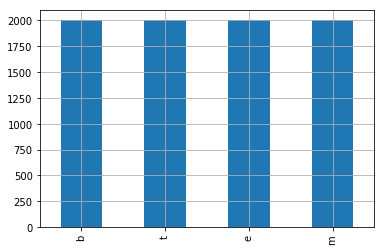

In [16]:
news.category.value_counts().plot(kind='bar',grid=True)
plt.show()

In [41]:
# clean data: remove punctuations, user mentions, hashtages and urls
def clean_text(tweet):
    #Convert to lower case
    tweet = tweet.lower()
    #Utility function to clean tweet text by removing links, special characters using simple regex statements.
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)", " ", tweet).split())

news['text'] = [clean_text(s) for s in news['title']]

#Tokenization  
def tokenizer(text):
    try:
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent

        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', 
                                            u'\u2014', u'\u2026', u'\u2013'], tokens))
        #Stemming, reduce topically similar words to their root
        tokens = [p_stemmer.stem(t) for t in tokens]
        
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)

        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

        return filtered_tokens
    except Error as e:
        print(e)
        
news['tokens'] = news['text'].map(tokenizer)

news.head(5)


,id,title,url,publisher,category,story,hostname,timestamp,text,tokens
364598,364599,VIDEO: Two planes have serious near-miss at Ba...,http://www.breakingnews.ie/discover/video-two-...,BreakingNews.ie,b,dUAXUDNU8EuVDUMCq0qglFi336usM,www.breakingnews.ie,1.404760e+12,video two planes have serious near miss at bar...,"[video, two, plane, seriou, near, miss, barcel..."
90891,90892,"IMF Says US Growth Leads as Russia, Brazil Sof...",http://www.businessweek.com/news/2014-04-08/im...,Businessweek,b,dxB9Hik1YGyfVaMk796CJSnAf58bM,www.businessweek.com,1.396990e+12,imf says us growth leads as russia brazil soft...,"[imf, say, us, growth, lead, russia, brazil, s..."
173354,173355,ECB Squeezed And EBA Posts Stress Test Scenarios,http://seekingalpha.com/article/2172223-ecb-sq...,Seeking Alpha,b,d6oH4km9IXNQhDMMjOqbrYbTbVjcM,seekingalpha.com,1.398860e+12,ecb squeezed and eba posts stress test scenarios,"[ecb, squeez, eba, post, stress, test, scenario]"
196094,196095,Yellen: Raising Minimum Wage Would Have Positi...,http://www.nasdaq.com/article/yellen-raising-m...,NASDAQ,b,d06p_B068Tz-trM0VOb3T9IS-s-rM,www.nasdaq.com,1.399620e+12,yellen raising minimum wage would have positiv...,"[yellen, rais, minimum, wage, would, posit, ne..."
44394,44395,Top JPMorgan Exec Cavanagh Jumps to Carlyle Group,http://www.foxbusiness.com/industries/2014/03/...,Fox Business,b,dTHeoUzEPQp6XNMPBKBlQ9ys5UB4M,www.foxbusiness.com,1.395830e+12,top jpmorgan exec cavanagh jumps to carlyle group,"[top, jpmorgan, exec, cavanagh, jump, carlyl, ..."


In [18]:
#group the tokens by category, apply a word count and display the top 10 most frequent tokens
def keywords(category):
    tokens = news[news['category'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(10)

for category in set(news['category']):
    print('category :', category)
    print('top 10 keywords:', keywords(category))
    print('---')

category : e
top 10 keywords: [('new', 116), ('video', 78), ('season', 76), ('kim', 72), ('kardashian', 72), ('game', 66), ('star', 65), ('review', 63), ('movie', 63), ('first', 56)]
---
category : m
top 10 keywords: [('ebola', 192), ('study', 145), ('cancer', 131), ('new', 120), ('health', 119), ('may', 95), ('virus', 94), ('us', 91), ('mers', 86), ('outbreak', 80)]
---
category : t
top 10 keywords: [('google', 224), ('apple', 172), ('new', 156), ('samsung', 132), ('microsoft', 106), ('facebook', 104), ('galaxy', 97), ('android', 81), ('one', 76), ('us', 64)]
---
category : b
top 10 keywords: [('us', 195), ('china', 100), ('stocks', 90), ('new', 78), ('says', 61), ('bank', 60), ('market', 57), ('billion', 56), ('sales', 56), ('data', 50)]
---


In [23]:
# min_df is minimum number of documents that contain a term t
# max_features is maximum number of unique tokens (across documents) that we'd consider
# TfidfVectorizer preprocesses the descriptions using the tokenizer we defined above
vectorizer = TfidfVectorizer(min_df=10, max_features=None, tokenizer=tokenizer, ngram_range=(1, 2))

# vz is a tfidf matrix
#its number of rows is the total number of news
#its number of columns is the total number of unique terms (tokens) across the news
vz = vectorizer.fit_transform(list(news['text']))
vz.shape

(422937, 20000)

In [24]:
#a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [26]:
#display the 30 tokens that have the lowest tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=True).head(30)

,tfidf
new,3.866509
us,4.197676
google,4.555757
apple,4.715082
video,4.783485
says,4.845456
first,4.918875
samsung,4.962175
may,4.999920
microsoft,5.098605


In [27]:
#check out the 30 words with the highest tfidf scores
tfidf.sort_values(by=['tfidf'], ascending=False).head(30)

,tfidf
blah,11.557086
cha cha,10.910458
quot,10.819487
ctos,10.776927
little bit,10.776927
yeah,10.776927
peer,10.776927
hummus dips,10.736105
un agency,10.736105
boj kuroda,10.736105


In [42]:
news = news[~news['category'].isnull()& ~news['text'].isnull()]

# pull the data into vectors
vectorizer = CountVectorizer(min_df=10, max_features=None, tokenizer=tokenizer)
x_vec = vectorizer.fit_transform(news['text'])

encoder = LabelEncoder()
ncategory = encoder.fit_transform(news['category'])

x_train, x_test, y_train, y_test = train_test_split(np.array(news['text']),ncategory, test_size=0.2, stratify=ncategory)

In [43]:
y_train_p=[[y_train[i]] for i in range(len(y_train))]

In [ ]:
from sklearn.svm import SVC

model_SVC.fit(x_train[:100000], y_train[:100000])

[LibSVM]

In [16]:
y_pred=model_SVC.predict(x_test)
labels = list(set(news['category']))
metrics.classification_report(y_test, y_pred, target_names=labels)

'             precision    recall  f1-score   support\n\n          t       0.97      0.02      0.05     23209\n          e       0.99      0.28      0.44     30694\n          b       0.93      0.29      0.45      9178\n          m       0.30      1.00      0.46     21505\n\navg / total       0.80      0.39      0.34     84586\n'

In [22]:
# the Naive Bayes model

nb = MultinomialNB()
nb.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [23]:
y_pred=nb.predict(x_test)
print(metrics.classification_report(y_test, y_pred, target_names=labels))

             precision    recall  f1-score   support

          t       0.91      0.90      0.90     23194
          e       0.96      0.96      0.96     30564
          b       0.92      0.92      0.92      9128
          m       0.89      0.91      0.90     21700

avg / total       0.92      0.92      0.92     84586



In [44]:
text_clf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())])
text_clf.fit(x_train, y_train_p)


C:\ANACONDA\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [45]:
y_pred=text_clf.predict(x_test)
labels = list(set(news['category']))
print(metrics.classification_report(y_test, y_pred, target_names=labels))

             precision    recall  f1-score   support

          e       0.87      0.77      0.82       400
          m       0.91      0.91      0.91       400
          t       0.90      0.91      0.90       400
          b       0.80      0.87      0.83       400

avg / total       0.87      0.86      0.86      1600



In [33]:
#visulize the topic categories
#reducing the dimension of each vector to 50 by SVD.
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(x_vec)

from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_vec = tsne_model.fit_transform(svd_tfidf)

tsne_df = pd.DataFrame(tsne_vec, columns=['x', 'y'])
tsne_df['text'] = news['text']
tsne_df['category'] = ncategory

plot_news = bp.figure(plot_width=700, plot_height=600, title="A map of news",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

colormap = np.array(["#6d8dca", "#69de53","#723bca", "#c3e14c"])
plot_news.scatter(x='x', y='y', 
                    color=colormap[tsne_df['category']], 
                    source=tsne_df)
hover = plot_news.select(dict(type=HoverTool))
hover.tooltips={"text": "@text", "category": "@category"}
show(plot_news) 
                   

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.256771
[t-SNE] Error after 350 iterations: 1.256771


C:\ANACONDA\envs\tensorflow\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
C:\ANACONDA\envs\tensorflow\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


In [34]:
n_topics = 4
n_iter = 2000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(x_vec)

INFO:lda:n_documents: 8000
INFO:lda:vocab_size: 1262
INFO:lda:n_words: 32138
INFO:lda:n_topics: 4
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -315369
INFO:lda:<10> log likelihood: -243829
INFO:lda:<20> log likelihood: -237826
INFO:lda:<30> log likelihood: -235590
INFO:lda:<40> log likelihood: -234344
INFO:lda:<50> log likelihood: -233256
INFO:lda:<60> log likelihood: -232531
INFO:lda:<70> log likelihood: -231720
INFO:lda:<80> log likelihood: -231218
INFO:lda:<90> log likelihood: -230867
INFO:lda:<100> log likelihood: -230534
INFO:lda:<110> log likelihood: -230161
INFO:lda:<120> log likelihood: -229645
INFO:lda:<130> log likelihood: -229366
INFO:lda:<140> log likelihood: -229204
INFO:lda:<150> log likelihood: -228933
INFO:lda:<160> log likelihood: -228619
INFO:lda:<170> log likelihood: -228461
INFO:lda:<180> log likelihood: -228263
INFO:lda:<190> log likelihood: -228130
INFO:lda:<200> log likelihood: -227941
INFO:lda:<210> log likelihood: -227943
INFO:lda:<220> log likelihood: -2

In [37]:
X_topics

array([[ 0.02941176,  0.32352941,  0.61764706,  0.02941176],
       [ 0.01351351,  0.95945946,  0.01351351,  0.01351351],
       [ 0.02272727,  0.47727273,  0.02272727,  0.47727273],
       ..., 
       [ 0.04166667,  0.45833333,  0.04166667,  0.45833333],
       [ 0.875     ,  0.04166667,  0.04166667,  0.04166667],
       [ 0.02272727,  0.02272727,  0.93181818,  0.02272727]])

In [35]:
tsne_lda = tsne_model.fit_transform(X_topics)
lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['len_docs'] = news['tokens'].map(len)
def prepareLDAData():
    data = {
        'vocab': vectorizer.get_feature_names(),
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':vectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.759967
[t-SNE] Error after 300 iterations: 0.759967


In [36]:
ldadata=prepareLDAData()
import pyLDAvis
pyLDAvis.enable_notebook()
prepared_data=pyLDAvis.prepare(**ldadata)
pyLDAvis.save_html(prepared_data,'./pyldadavis.html')